In [25]:
import numpy as np
import scipy.io as sio
import matplotlib.pyplot as plt
import math
from scipy import ndimage as ndi
from skimage.feature import peak_local_max
import scipy.misc

In [58]:
# path to raw data, denoised data, and ground truth
# no data exceeds 2GB thus they are all saved in .mat or .py
path ='D:/2020/TensorSVD/ManuscriptRelated/SimulationData/'
raw_data = sio.loadmat(path + 'DenoiseInput_fullsize/SiDislocation/Simulation_noisy_SiDisl_slc5_1000FPS.mat')
raw_data = raw_data['datacube']

truth_data = np.load(path + 'DenoiseInput_fullsize/SiDislocation/Simulation_truth_SiDisl_slc5_1000FPS.npy')

denoised_data = sio.loadmat(path + 'DenoiseOutput_fullsize/SiDislocation/Simulation_tensor_SiDisl_slc5_1000FPS.mat')
denoised_data = denoised_data['est_HOOI']

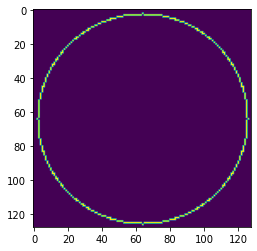

In [59]:
# A circular mask with less points can be generated by using a smaller gap between two radii
circular_mask = create_circular_mask(128, 128, center=(64,64), radius=62) & \
~create_circular_mask(128, 128, center=(64,64), radius=61)
plt.imshow(circular_mask)
ADF_noisy = np.zeros((raw_data.shape[0],raw_data.shape[1]))
ADF_denoised = np.zeros((raw_data.shape[0],raw_data.shape[1]))
ADF_truth = np.zeros((raw_data.shape[0],raw_data.shape[1]))

for i in range(128):
    for j in range(128):
        if circular_mask[i,j] == 1:
            ADF_noisy = ADF_noisy + raw_data[:,:,i*128+j]
            ADF_denoised = ADF_denoised + denoised_data[:,:,i*128+j]
            ADF_truth = ADF_truth + truth_data[:,:,i*128+j]

(-0.5, 113.5, 113.5, -0.5)

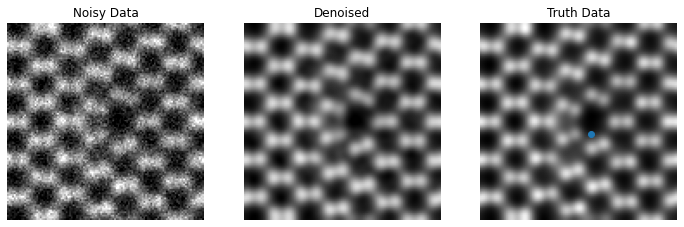

In [60]:
# Compare real space structure from ADF reconstrcutred from a ring with width = 1
plt.figure(figsize=(12,4))
clim_low = np.amin(ADF_truth)
clim_high = np.amax(ADF_truth)

plt.subplot(132)
plt.imshow(ADF_denoised,clim=[clim_low,clim_high],cmap='gray')
# plt.colorbar()
plt.axis('off')
plt.title('Denoised')

plt.subplot(131)
plt.imshow(ADF_noisy,clim=[clim_low,clim_high],cmap='gray')
plt.title('Noisy Data')
plt.axis('off')
# plt.colorbar()

plt.subplot(133)
plt.imshow(ADF_truth,clim=[clim_low,clim_high],cmap='gray')
plt.title('Truth Data')
plt.scatter(64,64)
plt.axis('off')
# plt.colorbar()

In [61]:
scipy.misc.imsave('noisy.tiff', ADF_noisy)
scipy.misc.imsave('denoised.tiff', ADF_denoised)
scipy.misc.imsave('truth.tiff', ADF_truth)

C:\Users\Chenyu\AppData\Roaming\Python\Python36\site-packages\ipykernel_launcher.py:1: DeprecationWarning: `imsave` is deprecated!
`imsave` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imwrite`` instead.
  """Entry point for launching an IPython kernel.
C:\Users\Chenyu\AppData\Roaming\Python\Python36\site-packages\ipykernel_launcher.py:2: DeprecationWarning: `imsave` is deprecated!
`imsave` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imwrite`` instead.
  
C:\Users\Chenyu\AppData\Roaming\Python\Python36\site-packages\ipykernel_launcher.py:3: DeprecationWarning: `imsave` is deprecated!
`imsave` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imwrite`` instead.
  This is separate from the ipykernel package so we can avoid doing imports until


## Fit all the Si positions on Silicon using Igor
The fitting of the Si dumbbells need to fit each dumbbell to a sum of two Gaussian functions. So far, I don't have a good way to do it in Python.
<br>The fitting of the atom positions around the dislocation core could be hard, as the peak shapes are not very round in the denoised image or noisy data. It seems fitting window with 16px-by-8px size with initial peak position set to (center_x +/- 3px, center_y) for 1000-40000 FPS data.
<br>The only exception is for denoised 1000FPS data, 16px by 10px size box used.

<br>Under each set of AtomPositions.mat file, there is a total three variables saving the fitted atom positions of noisy image, denoised image, and ground truth.
Within each variable, the first column contains the x coordinates and the second column contains the y coordinates.

In [79]:
path ='D:/2020/TensorSVD/ManuscriptRelated/SimulationData/'
atom_positions = sio.loadmat(path + 'DenoiseOutput_fullsize/SiDislocation/AtomPositions_4000FPS.mat')
noisy_positions = atom_positions['Si_noisy']
denoised_positions = atom_positions['Si_denoised']
truth_positions = atom_positions['Si_truth']

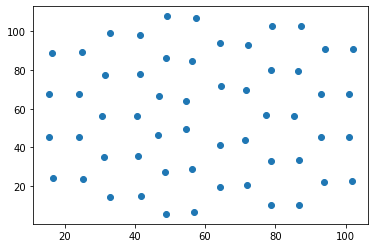

In [80]:
diff_noisy = noisy_positions - truth_positions
diff_denoised = denoised_positions - truth_positions
plt.scatter(truth_positions[:,0],truth_positions[:,1])

(-1.9, 1.9)

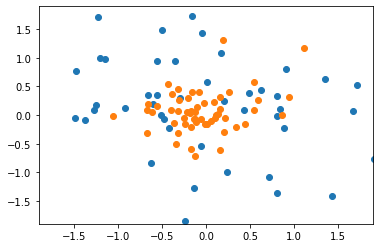

In [81]:
plt.scatter(diff_noisy[:,0],diff_noisy[:,1])
plt.scatter(diff_denoised[:,0],diff_denoised[:,1])
plt.xlim([-1.9,1.9])
plt.ylim([-1.9,1.9])

## Functions that will be called

In [3]:
def create_circular_mask(h, w, center=None, radius=None):

    if center is None: # use the middle of the image
        center = [int(w/2), int(h/2)]
    if radius is None: # use the smallest distance between the center and image walls
        radius = min(center[0], center[1], w-center[0], h-center[1])

    Y, X = np.ogrid[:h, :w]
    dist_from_center = np.sqrt((X - center[0])**2 + (Y-center[1])**2)

    mask = dist_from_center <= radius
    return mask

In [4]:
def fitGaussianx2(data, guess, bounds):
    x = np.linspace(0, data.shape[1]-1, data.shape[1])
    y = np.linspace(0, data.shape[0]-1, data.shape[0])
    x, y = np.meshgrid(x, y)
    xdata_tuple = (x,y)
    popt, pcov = optimize.curve_fit(gaussianx2, xdata_tuple, data.ravel(), p0=guess,bounds=bounds,method='trf',verbose=0,maxfev=100000)
    return popt

In [5]:
def gaussianx2(xdata_tuple,bg,height, center_x, center_y, width_x, width_y):

    (x, y) = xdata_tuple
    width_x = float(width_x)
    width_y = float(width_y)
    g = height*exp(
                 -(((center_x-x)/width_x)**2+((center_y-y)/width_y)**2)/2)+bg
    return g.ravel()